In [1]:
import os, re, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as colors

from pathlib import Path
from scipy.stats import pearsonr

all_hosps = "73-264-420-243-338-443-199-458-300-188-252-167-122"
hosp_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167, 122]

model = "K29"
log_dir = Path(f"../../yaib_logs/eicu/Mortality24/{model}/")
data_dir = Path("../../YAIB-cohorts/data/mortality24/eicu")

def read_k29_params(f: Path) -> dict:
    text = open(f, "r", encoding="utf-8").read()

    def grab(key: str) -> str:
        m = re.search(rf"(?m)^\s*{re.escape(key)}\s*=\s*([^#\n]+)", text)
        if not m:
            raise KeyError(f"Missing '{key}' in {f}")
        return m.group(1).strip()

    gamma = float(grab("K29Classifier.gamma"))
    n_rff = int(grab("K29Classifier.n_rff_features"))
    return {"gamma": gamma, "n_rff_features": n_rff}

In [2]:
df = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/sta.parquet', engine='pyarrow')
df_outc = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/outc.parquet', engine='pyarrow') # add outcome data

df = df.merge(df_outc, on='stay_id')

## K29 Results

Only 1 fold 1 repetition
Training on eicu with 31721 samples and validating on eicu with 3525 samples

/home/tane/YAIB/yaib_logs/eicu/Mortality24/K29/train73-264-420-243-338-443-199-458-300-188-252-167-122-test300/2025-12-
10T06-29-00/repetition_0/fold_0

In [3]:
# K29 one-to-one
n=1000
base_avg_dict = {} 

for i, hos in enumerate(hosp_ids): 
    dir_str = f"train-test{hos}-n{n}"
    exp_dir = os.path.join(log_dir, dir_str)
    try:
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]
        f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
        result_dict = json.load(f)
        for keyword, key_dict in zip(['avg'], [base_avg_dict]): 
            key_results = result_dict[keyword]
            for key in key_results.keys(): 
                if key not in key_dict:
                    key_dict[key] = {}
                key_dict[key][hos] = key_results[key]
    except Exception as e:
        print(exp_dir)
        print(e)
        print()

In [4]:
# K29 all data
# _cache 
# _catboost
all_avg_dict = {} 

for i, hos in enumerate(hosp_ids): 
    dir_str = f"train{all_hosps}-test{hos}_catboost"
    exp_dir = os.path.join(log_dir, dir_str)
    try:
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]
        f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
        result_dict = json.load(f)
        for keyword, key_dict in zip(['avg'], [all_avg_dict]): 
            key_results = result_dict[keyword]
            for key in key_results.keys(): 
                if key not in key_dict:
                    key_dict[key] = {}
                key_dict[key][hos] = key_results[key]
    except Exception as e:
        print(exp_dir)
        print(e)
        print()

config_f = os.path.join(exp_dir, datetime, 'repetition_0', 'fold_0', 'train_config.gin')
hparams = read_k29_params(config_f)
all_avg_dict = all_avg_dict | hparams


../../yaib_logs/eicu/Mortality24/K29/train73-264-420-243-338-443-199-458-300-188-252-167-122-test73_catboost
[Errno 2] No such file or directory: '../../yaib_logs/eicu/Mortality24/K29/train73-264-420-243-338-443-199-458-300-188-252-167-122-test73_catboost/2026-01-14T09-40-44/accumulated_test_metrics.json'

../../yaib_logs/eicu/Mortality24/K29/train73-264-420-243-338-443-199-458-300-188-252-167-122-test264_catboost
[Errno 2] No such file or directory: '../../yaib_logs/eicu/Mortality24/K29/train73-264-420-243-338-443-199-458-300-188-252-167-122-test264_catboost/2026-01-14T09-40-44/accumulated_test_metrics.json'

../../yaib_logs/eicu/Mortality24/K29/train73-264-420-243-338-443-199-458-300-188-252-167-122-test420_catboost
[Errno 2] No such file or directory: '../../yaib_logs/eicu/Mortality24/K29/train73-264-420-243-338-443-199-458-300-188-252-167-122-test420_catboost/2026-01-14T09-40-44/accumulated_test_metrics.json'

../../yaib_logs/eicu/Mortality24/K29/train73-264-420-243-338-443-199-458

KeyError: "Missing 'K29Classifier.gamma' in ../../yaib_logs/eicu/Mortality24/K29/train73-264-420-243-338-443-199-458-300-188-252-167-122-test122_catboost/2026-01-14T09-40-44/repetition_0/fold_0/train_config.gin"

In [5]:
catboost_dict = {} 

for i, hos in enumerate(hosp_ids): 
    dir_str = f"train{all_hosps}-test{hos}_id"
    exp_dir = os.path.join(Path(f"../../yaib_logs/eicu/Mortality24/CatBoostClassifier/"), dir_str)
    try:
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]
        f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
        result_dict = json.load(f)
        for keyword, key_dict in zip(['avg'], [catboost_dict]): 
            key_results = result_dict[keyword]
            for key in key_results.keys(): 
                if key not in key_dict:
                    key_dict[key] = {}
                key_dict[key][hos] = key_results[key]
    except Exception as e:
        print(exp_dir)
        print(e)
        print()

rbf_dict = {} 

for i, hos in enumerate(hosp_ids): 
    dir_str = f"train{all_hosps}-test{hos}_id"
    exp_dir = os.path.join(Path(f"../../yaib_logs/eicu/Mortality24/LogisticRegressionRBF/"), dir_str)
    try:
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]
        f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
        result_dict = json.load(f)
        for keyword, key_dict in zip(['avg'], [rbf_dict]): 
            key_results = result_dict[keyword]
            for key in key_results.keys(): 
                if key not in key_dict:
                    key_dict[key] = {}
                key_dict[key][hos] = key_results[key]
    except Exception as e:
        print(exp_dir)
        print(e)
        print()

In [6]:
all_df = pd.DataFrame.from_dict(all_avg_dict)
base_df = pd.DataFrame.from_dict(base_avg_dict)

catboost_df = pd.DataFrame.from_dict(catboost_dict)
rbf_df = pd.DataFrame.from_dict(rbf_dict)

In [11]:
col = 'ACC_TEST'

pd.DataFrame({'K29 base': base_df[col], 'K29 all': all_df[col], 'catboost': catboost_df[col], 'LR w/ RBF': rbf_df[col]})

,K29 base,K29 all,catboost,LR w/ RBF
73,0.8956,0.9777,0.9737,0.98500
264,0.8920,0.9346,0.9334,0.93300
420,0.8726,0.8280,0.9006,0.89200
243,0.9328,0.9410,0.9557,0.94837
338,0.8899,0.8771,0.9417,0.93410
443,0.8851,0.9136,0.8842,0.89330
199,0.8536,0.8998,0.9246,0.92530
458,0.8901,0.8475,0.8913,0.87720
300,0.8569,0.8904,0.9234,0.91070
188,0.8709,0.9014,0.9136,0.90740


In [8]:
x_iters = np.array(data["x_iters"])
f = np.array(data["func_vals"])

x, y = x_iters[:, 0], x_iters[:, 1]

vmin, vmax = np.percentile(f, [5, 95])  # tweak 1–10 / 90–99 if needed

plt.figure(figsize=(7, 5))
sc = plt.scatter(
    x, y, c=f, s=40,
    cmap="viridis",
    norm=colors.Normalize(vmin=vmin, vmax=vmax)
)
plt.colorbar(sc, label="func_vals")
plt.yscale('log')
plt.xlabel("n_rff_features")
plt.ylabel("gamma")
plt.tight_layout()
plt.show()


NameError: name 'data' is not defined

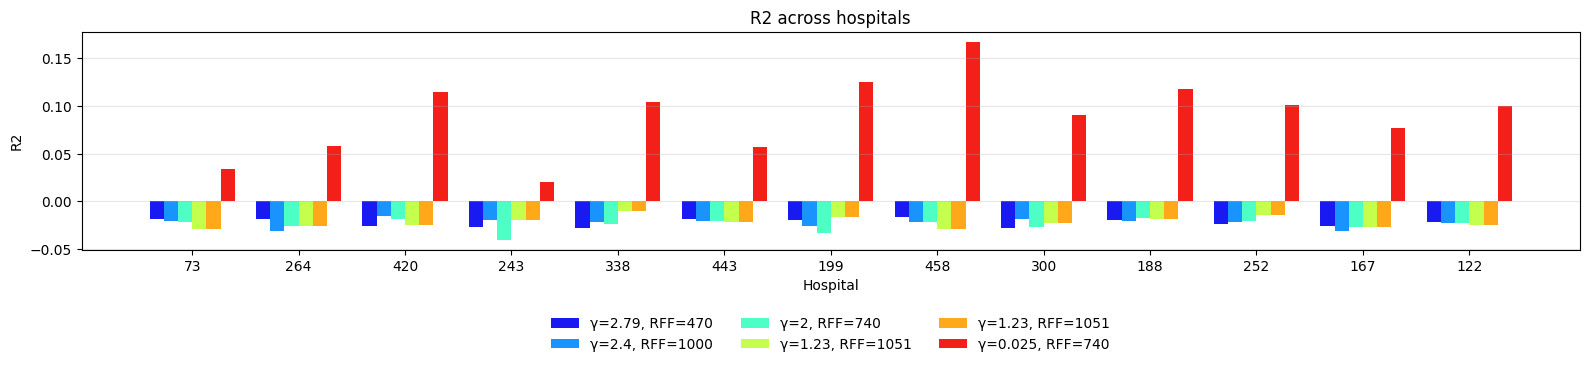

In [9]:
def collect_experiments(log_dir, hosp_ids, metric_key, k=6):
    """
    Returns:
        values: (k, n_hospitals)
        labels: list of hparam strings
    """
    values = []
    labels = []

    for hos in hosp_ids:
        dir_str = f"train{all_hosps}-test{hos}"
        exp_dir = os.path.join(log_dir, dir_str)

        files = sorted(os.listdir(exp_dir))
        selected = files[-k:]   # last k experiments

        for i, dt in enumerate(selected):
            # metrics
            with open(os.path.join(exp_dir, dt, "accumulated_test_metrics.json")) as f:
                result = json.load(f)

            if len(values) <= i:
                values.append([])
                # read hparams once per experiment
                gin_path = os.path.join(
                    exp_dir, dt, "repetition_0", "fold_0", "train_config.gin"
                )
                h = read_k29_params(gin_path)
                labels.append(f"γ={h['gamma']:.3g}, RFF={h['n_rff_features']}")

            values[i].append(result["avg"][metric_key])

    return np.array(values), labels

def plot_grouped_bars(values, hosp_ids, labels, metric_key):
    import numpy as np
    import matplotlib.pyplot as plt

    n_exp, n_hosp = values.shape
    x = np.arange(n_hosp)
    width = 0.8 / n_exp

    plt.figure(figsize=(16, 4))

    cmap = plt.get_cmap("jet")
    # colors = [cmap(i % cmap.N) for i in range(n_exp)]  
    colors = cmap(np.linspace(0.1, 0.9, n_exp))
    # colors = ['mediumseagreen', 'magenta', 'blue', 'tab:purple', 'tab:red', 'gold']

    for i in range(n_exp):
        plt.bar(
            x + (i - (n_exp - 1) / 2) * width,
            values[i],
            width,
            label=labels[i],
            color=colors[i],              # <- single color per experiment
            linewidth=0.3,
            alpha=0.9
        )

    plt.xticks(x, hosp_ids)
    plt.xlabel("Hospital")
    plt.ylabel(metric_key)
    plt.title(f"{metric_key} across hospitals")
    plt.grid(axis="y", alpha=0.3)

    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.25),
        ncol=min(3, n_exp),
        frameon=False
    )

    plt.tight_layout()
    plt.show()


metric_key = "R2"   # or any other key

values, labels = collect_experiments(
    log_dir=log_dir,
    hosp_ids=hosp_ids,
    metric_key=metric_key,
    k=6
)

plot_grouped_bars(values, hosp_ids, labels, metric_key)


### Calibration Curves

../../yaib_logs/eicu/Mortality24/K29/train73-264-420-243-338-443-199-458-300-188-252-167-122-test122
index 12 is out of bounds for axis 0 with size 12



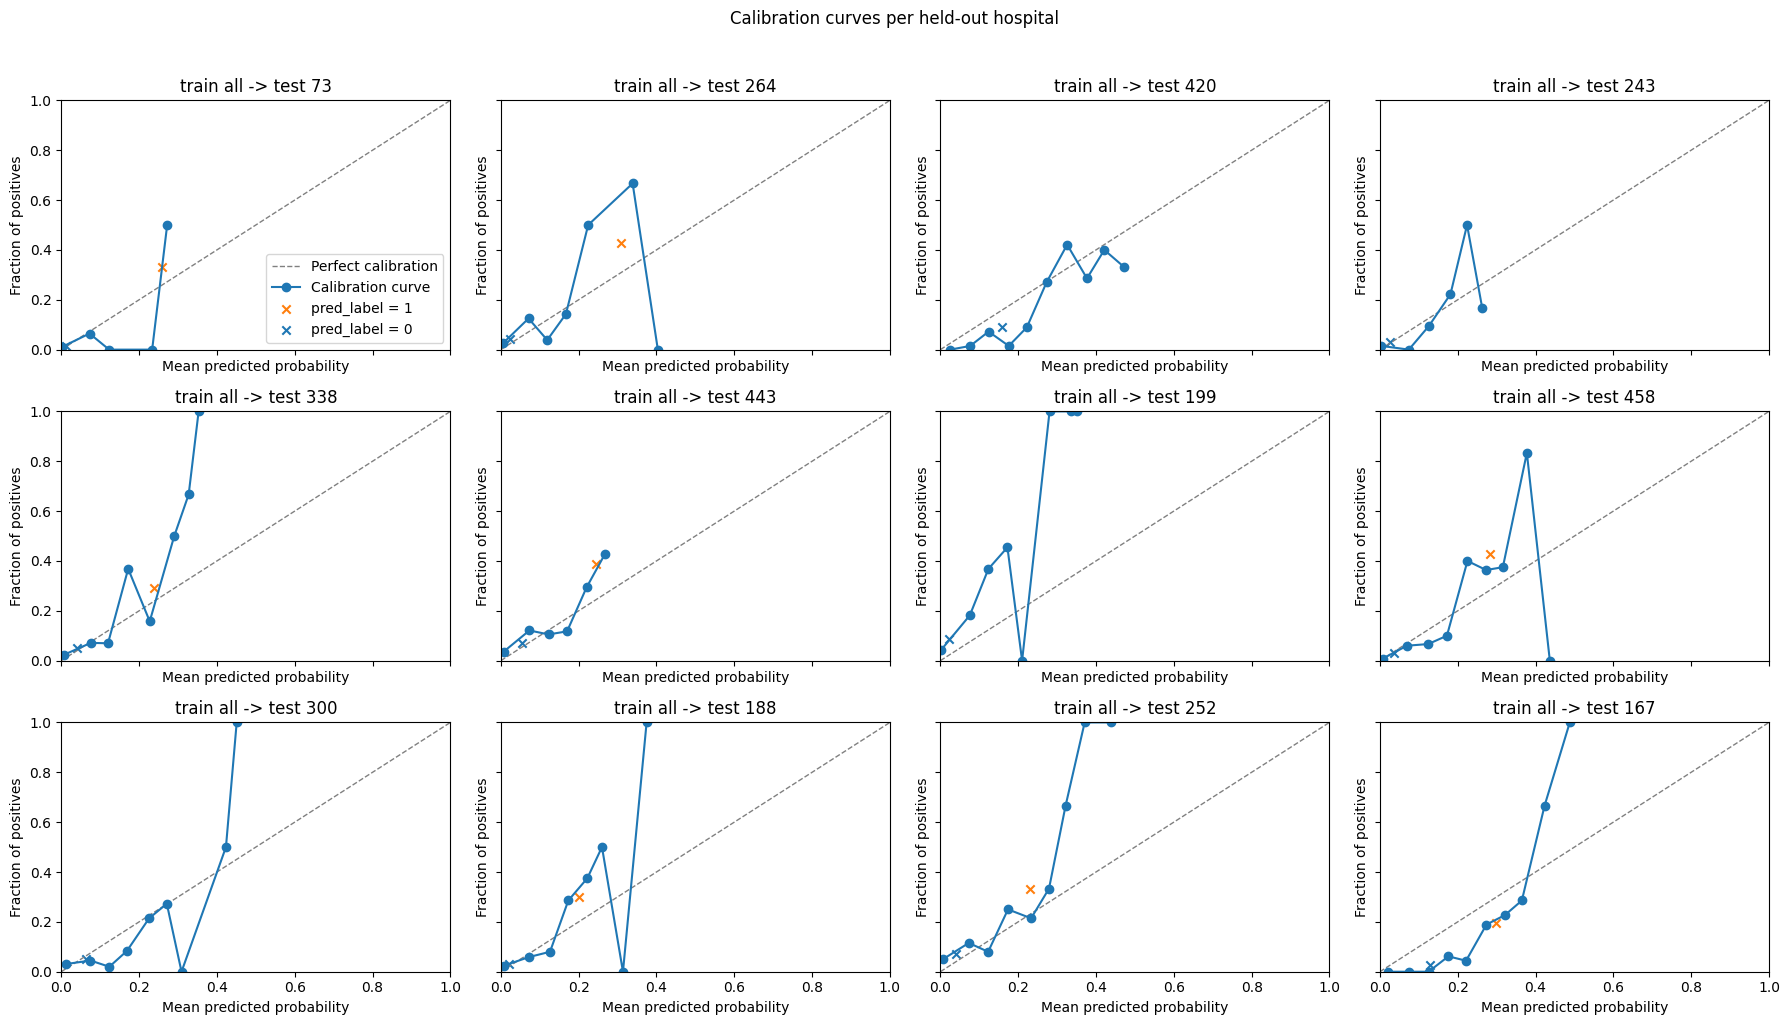

In [20]:
# K29 all data calibration curves
from sklearn.calibration import calibration_curve

n_bins = 20
fig, axes = plt.subplots(3, 4, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, hos in enumerate(hosp_ids):
    dir_str = f"train{all_hosps}-test{hos}"
    exp_dir = os.path.join(log_dir, dir_str)

    try:
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]
        data = np.load(os.path.join(exp_dir, datetime, 'repetition_0/fold_0/patient_results.npz'))

        y_prob = data['predictions']
        y_true = data['true_labels']
        y_pred = data['pred_labels']

        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')

        ax = axes[i]
        ax.plot([0, 1], [0, 1], '--', color='gray', linewidth=1, label='Perfect calibration' if i == 0 else None)
        ax.plot(prob_pred, prob_true, marker='o', label='Calibration curve' if i == 0 else None)

        pos_mask = y_pred == 1
        neg_mask = ~pos_mask
        if pos_mask.any():
            ax.scatter(y_prob[pos_mask].mean(), y_true[pos_mask].mean(), color='tab:orange', marker='x', label='pred_label = 1' if i == 0 else None)
        if neg_mask.any():
            ax.scatter(y_prob[neg_mask].mean(), y_true[neg_mask].mean(), color='tab:blue', marker='x', label='pred_label = 0' if i == 0 else None)

        ax.set_title(f"train all -> test {hos}")
        lim = max(max(prob_pred), max(prob_true))
        ax.set_xlim(0, lim)
        ax.set_ylim(0, lim)
        ax.set_xlabel('Mean predicted probability')
        ax.set_ylabel('Fraction of positives')

    except Exception as e:
        print(exp_dir)
        print(e)
        print()

for j in range(len(hosp_ids), len(axes)):
    axes[j].axis('off')

if axes.size:
    axes[0].legend(loc='lower right')

fig.suptitle('Calibration curves per held-out hospital', y=1.02)
fig.tight_layout()
plt.show()



../../yaib_logs/eicu/Mortality24/CatBoostClassifier/train73-264-420-243-338-443-199-458-300-188-252-167-122-test122_id
index 12 is out of bounds for axis 0 with size 12



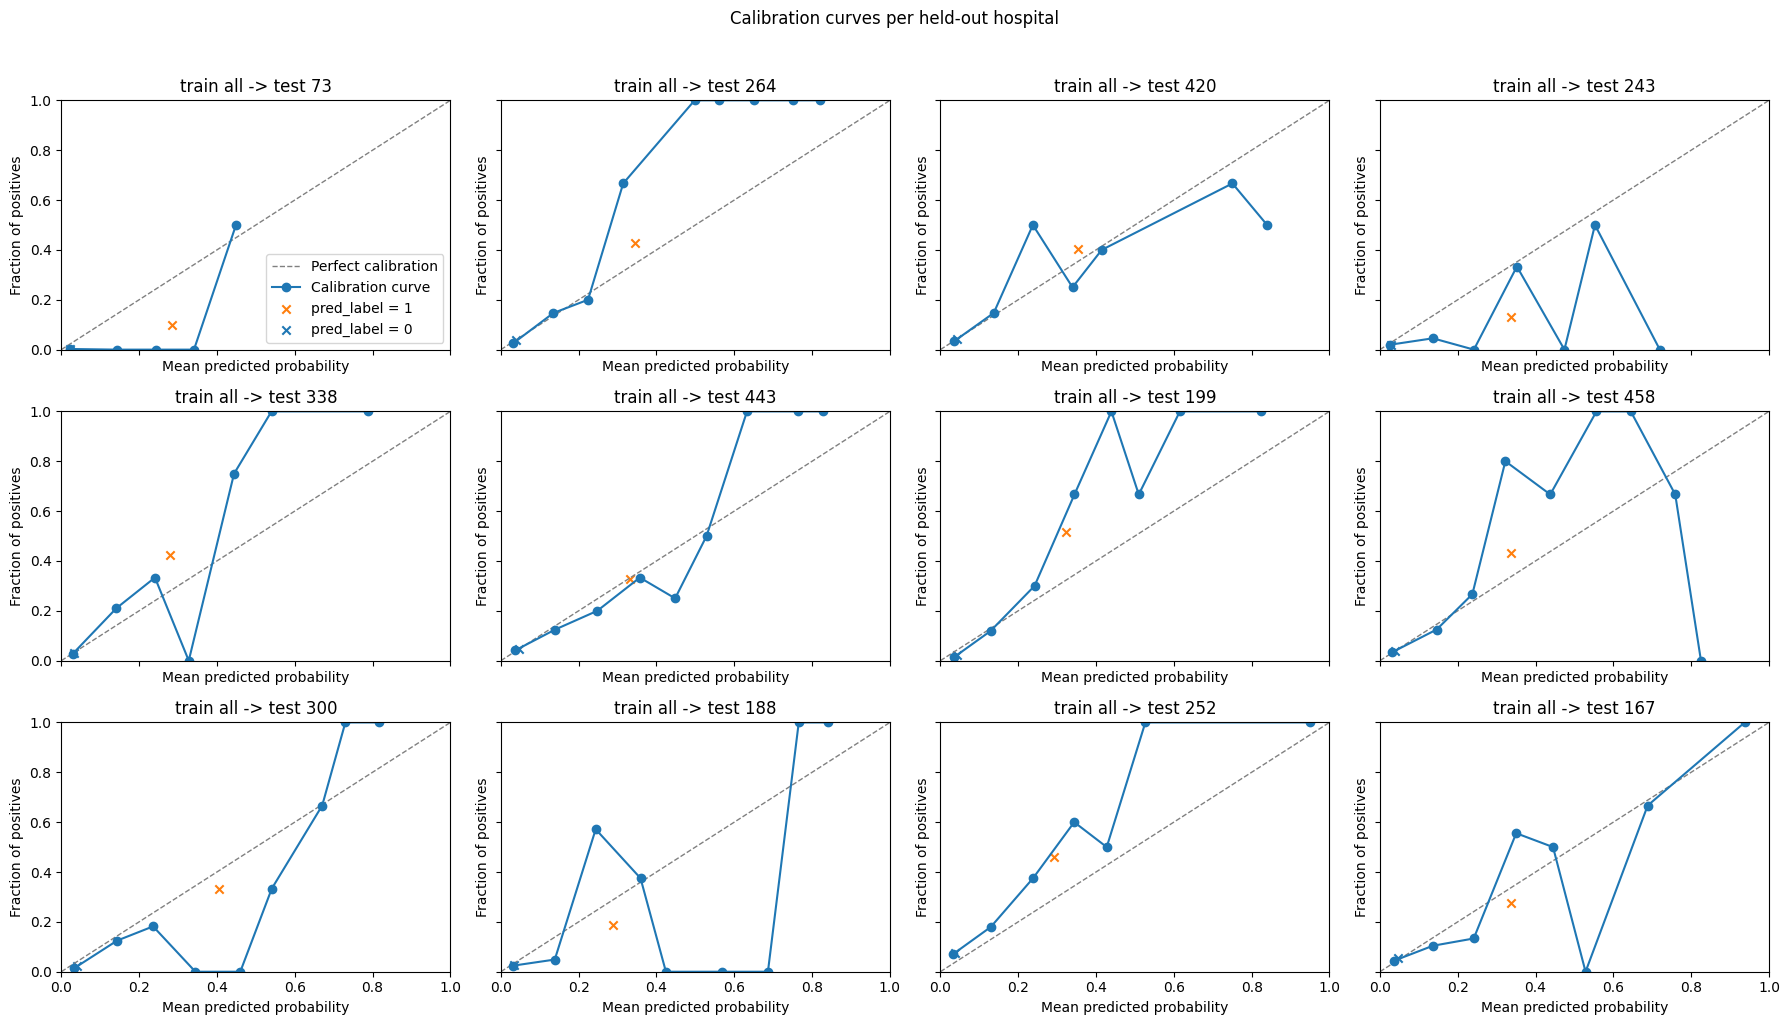

In [14]:
# K29 all data calibration curves
from sklearn.calibration import calibration_curve

n_bins = 10
fig, axes = plt.subplots(3, 4, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, hos in enumerate(hosp_ids):
    dir_str = f"train{all_hosps}-test{hos}_id"
    exp_dir = os.path.join(Path(f"../../yaib_logs/eicu/Mortality24/CatBoostClassifier/"), dir_str)

    try:
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]
        data = np.load(os.path.join(exp_dir, datetime, 'repetition_0/fold_0/patient_results.npz'))

        y_prob = data['predictions']
        y_true = data['true_labels']
        y_pred = data['pred_labels']

        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')

        ax = axes[i]
        ax.plot([0, 1], [0, 1], '--', color='gray', linewidth=1, label='Perfect calibration' if i == 0 else None)
        ax.plot(prob_pred, prob_true, marker='o', label='Calibration curve' if i == 0 else None)

        pos_mask = y_pred == 1
        neg_mask = ~pos_mask
        if pos_mask.any():
            ax.scatter(y_prob[pos_mask].mean(), y_true[pos_mask].mean(), color='tab:orange', marker='x', label='pred_label = 1' if i == 0 else None)
        if neg_mask.any():
            ax.scatter(y_prob[neg_mask].mean(), y_true[neg_mask].mean(), color='tab:blue', marker='x', label='pred_label = 0' if i == 0 else None)

        ax.set_title(f"train all -> test {hos}")
        lim = max(max(prob_pred), max(prob_true))
        ax.set_xlim(0, lim)
        ax.set_ylim(0, lim)
        ax.set_xlabel('Mean predicted probability')
        ax.set_ylabel('Fraction of positives')

    except Exception as e:
        print(exp_dir)
        print(e)
        print()

for j in range(len(hosp_ids), len(axes)):
    axes[j].axis('off')

if axes.size:
    axes[0].legend(loc='lower right')

fig.suptitle('Calibration curves per held-out hospital', y=1.02)
fig.tight_layout()
plt.show()

